In [89]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
from uavsar_pytools import UavsarScene
from constants import tol

In [2]:
boards = pd.read_parquet(Path('~/uavsar-validation/data/insitu/storm_boards.parq'))

<Axes: xlabel='elev_meters', ylabel='hn'>

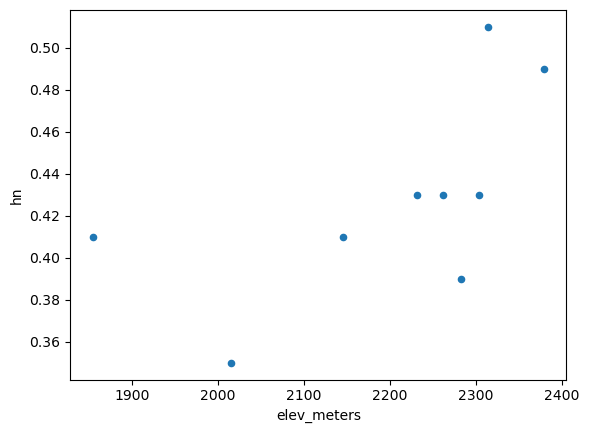

In [3]:
boards[(boards.date_t2 == '2021-02-03') & (boards.site.str.contains('MC'))].plot.scatter(x = 'elev_meters', y = 'hn')

<Axes: xlabel='elev_meters', ylabel='hn'>

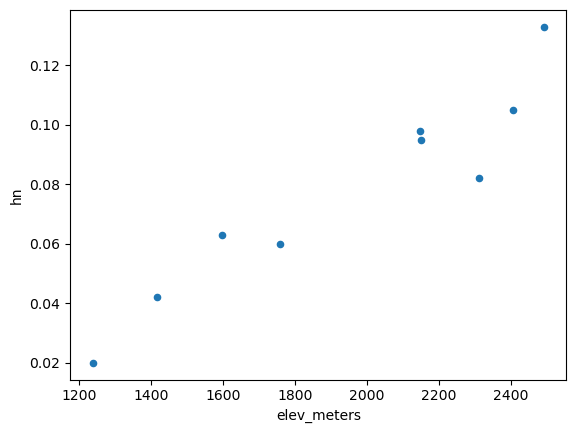

In [70]:
mc_boards = boards[(boards.date_t2 == '2021-02-10') & (boards.site.str.contains('LR')) & (~boards.comments.str.contains('Heavily')) & (boards.site != 'MC_1')]
mc_boards = gpd.GeoDataFrame(mc_boards, geometry=gpd.points_from_xy(mc_boards.longitude, mc_boards.latitude), crs="EPSG:4326")
mc_boards.plot.scatter(x = 'elev_meters', y = 'hn')

In [71]:
ds = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/old/232_2021-02-03_2021-02-10.sd.nc')
ds_mc = ds.rio.clip_box(*mc_boards.total_bounds)

<Axes: title={'center': 'band = VV, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

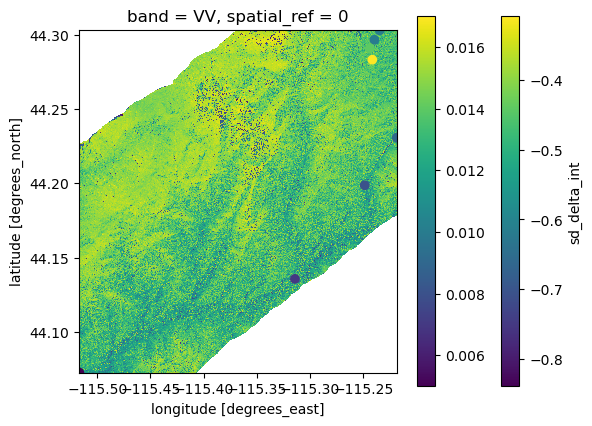

In [81]:
fig, ax = plt.subplots()
(ds_mc['sd_delta_int'].sel(band = 'VV') + ds['sd_delta_int'].sel(band = 'VV').min()).plot(ax = ax)
mc_boards.plot(ax = ax, column = 'swe', legend = True)

In [94]:
for i, r in mc_boards.iterrows():
    mc_boards.loc[i, 'int_swe'] = ds['sd_delta_unw'].sel(band = 'VV').sel(x = slice(r.geometry.x - 2*tol, r.geometry.x + 2*tol), y = slice(r.geometry.y + 2*tol, r.geometry.y - 2*tol)).mean() * (r.den / 997) + 0.028

<Axes: xlabel='elev_meters', ylabel='int_swe'>

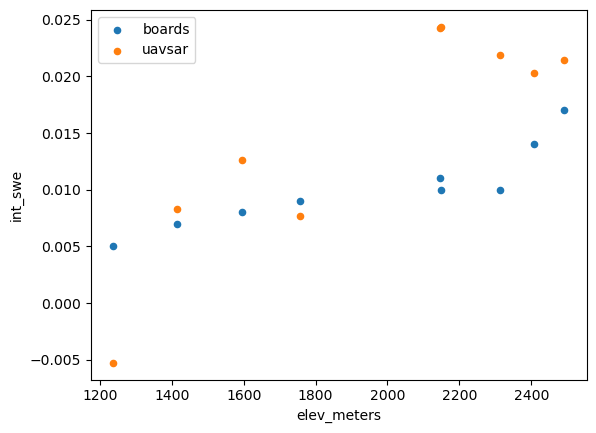

In [95]:
fig, ax = plt.subplots()
mc_boards.plot.scatter(x = 'elev_meters', y = 'swe', ax = ax, label = 'boards', color = 'C0')
mc_boards.plot.scatter(x = 'elev_meters', y = 'int_swe', ax = ax, label = 'uavsar', color = 'C1')